# How touristic the Greek Islands are?

First we gather the data by scraping the following website that lists the major inhabited islands in Greece 'https://simple.wikipedia.org/wiki/List_of_Greek_islands'. Greece has a large number of islands, with estimates ranging from somewhere around 1,200 to 6,000, depending on the minimum size to take into account. The number of inhabited islands is variously cited as between 166 and 227. However for purposed of this analysis the focus is on the major 40 islands that are the main touristic destinations since smaller islands are not in scope.

## Step 1 - Data Collection:
Source the data from the web

In [1]:
import requests
import lxml.html as lh
import pandas as pd

url='https://simple.wikipedia.org/wiki/List_of_Greek_islands'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#Add the headers
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name.rstrip(),[]))

In [2]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        
        #print(f'the data is: {data}')
        #print(f'the index i is: {i} and the index j is: {j}')
        #Append the data to the empty list of the i'th column
        col[i][1].append(data.rstrip())
        #print(f'the tuple is: {col}')
        #Increment i for the next column
        i+=1

In [13]:
#Assign the array to a dictionary and from there to a pandas data frame
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.shape

(40, 3)


## Step 2 - Data Manipulation:

With the data sored in a data frame we then perform a number of processing steps in order to make the data fit for our analysis:
1. we drop the Rank since it is not necessary for our analysis
2. we convert the area from string to int. To do that we first need to get rid of the '.' which make the conversion to fail and finally
3. we create a weight column by normalizing the size of the islands based on the size of the largest island. This is important since larger islands are expected to have more hotels, bars, etc.

In [14]:
df.drop('Rank by size',axis = 1, inplace = True)

#Convert the area from string to int in order to be able to perform calculations on it
df["Area (km²)"]=df["Area (km²)"].str.replace('.', '').astype(int)

#Normalize the since on the last column
maxArea = maxArea = df.max()['Area (km²)']
df['NormalSize'] = df.apply(lambda row: row['Area (km²)']/maxArea, axis=1)
df.head()

,Island name,Area (km²),NormalSize
0,Crete,8336,1.000000
1,Euboea,3655,0.438460
2,Lesbos,1630,0.195537
3,Rhodes,1398,0.167706
4,Chios,842,0.101008


In [6]:
df.tail()

,Area (km²),NormalSize
Island name,,
Thira (Santorini),76,0.009117
Serifos,73,0.008757
Sifnos,73,0.008757
Kasos,66,0.007917
Alonnisos,64,0.007678


## Step 3: Foursquare API

Next we will gather information from FourSquare on those islands.

In [8]:
from pandas.io.json import json_normalize

In [15]:
LIMIT = 1000
radius = 500

def requestFoursquareData(df):
    dataframe = pd.DataFrame()
    for i in range (0,len(df)):
    #for i in range (0,2):
        name = df.iloc[i]['Island name']
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&limit={}&radius={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        name,
        LIMIT,
        radius)
    
        results = requests.get(url).json()
    
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
    
        temp = json_normalize(venues)
        temp['Name'] = name
        dataframe = dataframe.append(temp, ignore_index = True, sort=True)
    return dataframe
#     print(dataframe.shape, temp.shape)


dataframe = requestFoursquareData(df)
dataframe.shape

(6260, 27)

By inspecting the data below it was identifies that for a few islands the country is not GR therefore Foursquare API has not returned the correct results for the venues. For those islands we either need to find a different name with which they are represented in the Foursquare API or exclude them from our analysis for now

In [16]:
temp = dataframe.groupby(['Name', 'location.cc']).size().unstack(fill_value=0)
temp.loc[temp['GR'] == 0]

location.cc,BR,GR,TR,US
Name,,,,
Crete,0,0,0,101
Ios,128,0,0,0
Ithaca,0,0,0,196


After a few trial with the API we've found the following replacements:
- Crete --> Creta
- Ithaca -->Ithaka
- Ios --> Íos

We've found that by manually inserting the latitude and longitude in the Foursquare API and observe some of the value returned.
Therefore we need to amend the dataframe with the island names and make the request again:

In [17]:
#Define a function to replace values in the island list
def replace_Island_Name(name, newName,islandList):
    index = islandList[islandList['Island name']==name].index.values.astype(int)[0]
    islandList.at[index,'Island name'] = newName

#Replace the three values
replace_Island_Name('Crete', 'Creta',df)
replace_Island_Name('Ithaca', 'Ithaka',df)
replace_Island_Name('Ios', 'Íos',df)

After replacing the values as mentioned above we call the Foursquare API once again. Following that we review the results once again we find that there are no results outside of Greece

In [18]:
dataframe = requestFoursquareData(df)

In [19]:
temp = dataframe.groupby(['Name', 'location.cc']).size().unstack(fill_value=0)
temp.loc[temp['GR'] == 0]

location.cc,GR,TR
Name,,


We then select only the category column and the columns that have the island name and the location country. The latter is selected because there is one row that has a country other than GR which needs to be removed. Some preprocessing is required to extract the category from the json object

In [20]:
temp = dataframe[['Name', 'categories', 'location.cc','location.lat','location.lng']]
temp = temp.rename(index=str, columns={'Name':'IslandName','categories':'Categories', 'location.cc':'Country', 'location.lng':'Longitude', 'location.lat':'Latitude'})

#exclude the non GR rows
temp = temp[temp.Country == 'GR']
#Drop the country column since it is no longer needed and get the category values from the json in the category
temp = temp[['IslandName','Categories','Latitude','Longitude']]

In [21]:
# Define a function to retrieve the category of the venue
def returnCategory(obj_list):
    category = ''
    if len(obj_list) > 0:
        category = obj_list[0]['name']
    return (category)

In [22]:
#Create a new column with the category and drop the original column

temp['Category'] = temp.Categories.apply(returnCategory)

temp = temp[['IslandName','Category','Latitude','Longitude']]

In [23]:
temp.head()

,IslandName,Category,Latitude,Longitude
0,Creta,Port,35.342184,25.141979
1,Creta,Boat or Ferry,35.340582,25.142575
2,Creta,Boat or Ferry,35.339764,25.133120
3,Creta,Travel Agency,35.341988,25.141590
4,Creta,Boat or Ferry,35.342155,25.141182


With the category in place we review the unique values with the ultimate goal to create our feature list for each island which will be wether they have port/airport, the number of hotels and the number of bars/coffee shops and restaurants they have.

In [24]:
temp.Category.unique()

array(['Port', 'Boat or Ferry', 'Travel Agency',
       'Tourist Information Center', 'Seafood Restaurant', 'Fish Taverna',
       'Snack Place', 'Sports Club', '', 'Government Building',
       'Gas Station', 'Gym / Fitness Center', 'Rental Car Location',
       'Theme Park', 'Music Venue', 'Bus Station', 'Cruise',
       'Other Nightlife', 'Bank', 'Bookstore', 'Nail Salon', 'Hobby Shop',
       'Theater', 'Coffee Shop', 'Park', 'Souvlaki Shop',
       'Greek Restaurant', 'Mediterranean Restaurant', 'Pizza Place',
       'Playground', 'College Administrative Building', 'Building',
       'Military Base', 'Fast Food Restaurant', 'Public Art',
       'Historic Site', 'Social Club', 'Bowling Alley', 'Club House',
       'Food Truck', 'Café', 'Electronics Store', 'Rock Club',
       'Nightclub', 'Bar', 'Health & Beauty Service', 'Pet Store',
       'Steakhouse', 'Convenience Store', 'Bus Line', 'Hotel', 'Bus Stop',
       'Bed & Breakfast', 'Jewelry Store', 'Newsstand', 'Moving Target',
 

After carefully reviewing the different categories in the Foursquare data we decided that the following belong to accomodation and food entertainment:
- **Accomodation:** 'Hotel','Bed & Breakfast','Vacation Rental','Resort','Residential Building (Apartment / Condo)','Spa','Hotel Bar','Hostel','Motel'
- **Food Entertainment:** 'Greek Restaurant','CafÃ©','Bar','Bakery','Cocktail Bar','Dessert Shop','Coffee Shop','Nightclub','Souvlaki Shop','Pizza Place','Taverna','Fast Food Restaurant','Restaurant','Grocery Store','Snack Place','Seafood Restaurant','Italian Restaurant','Kafenio','Mediterranean Restaurant','Meze Restaurant','Fish Taverna','Burger Joint','Breakfast Spot','Sandwich Place','Candy Store','Creperie','Food & Drink Shop','Frozen Yogurt Shop','Ouzeri','Bistro','Deli / Bodega','Internet Cafe','Food','Modern Greek Restaurant','Bougatsa Shop','Donut Shop','Pub','Steakhouse','Grilled Meat Restaurant','Cafeteria','Chinese Restaurant','Cupcake Shop','Falafel Restaurant','Juice Bar','Cretan Restaurant','Diner','Sushi Restaurant','Karaoke Bar','Fish & Chips Shop','Paella Restaurant','Piano Bar','Turkish Restaurant'

In [25]:
def isAccomodation(category):
    AccList = ['Hotel','Bed & Breakfast','Vacation Rental','Resort','Residential Building (Apartment / Condo)','Spa','Hotel Bar','Hostel','Motel']
    if AccList.count(category):
        return 1
    else:
        return 0
def isFoodEntertainment(category):
    FooEntList = ['Greek Restaurant','Café','Bar','Bakery','Cocktail Bar','Dessert Shop','Coffee Shop','Nightclub','Souvlaki Shop','Pizza Place','Taverna','Fast Food Restaurant','Restaurant','Grocery Store','Snack Place','Seafood Restaurant','Italian Restaurant','Kafenio','Mediterranean Restaurant','Meze Restaurant','Fish Taverna','Burger Joint','Breakfast Spot','Sandwich Place','Candy Store','Creperie','Food & Drink Shop','Frozen Yogurt Shop','Ouzeri','Bistro','Deli / Bodega','Internet Cafe','Food','Modern Greek Restaurant','Bougatsa Shop','Donut Shop','Pub','Steakhouse','Grilled Meat Restaurant','Cafeteria','Chinese Restaurant','Cupcake Shop','Falafel Restaurant','Juice Bar','Cretan Restaurant','Diner','Sushi Restaurant','Karaoke Bar','Fish & Chips Shop','Paella Restaurant','Piano Bar','Turkish Restaurant']
    if FooEntList.count(category):
        return 1
    else:
        return 0

temp['isAccomodation'] = temp.Category.apply(isAccomodation)
temp['isFoodEntertainment'] = temp.Category.apply(isFoodEntertainment)

In [26]:
sum_df = temp.groupby(['IslandName']).agg({'isAccomodation':'sum','isFoodEntertainment':'sum','Latitude':'mean','Longitude':'mean'})

In [27]:
sum_df_normalised = sum_df

In [28]:
df.set_index('Island name', inplace=True)
sum_df_normalised = sum_df_normalised.merge(df,left_index=True, right_index=True)

In [29]:
sum_df_normalised.head()
sum_df.head()

,isAccomodation,isFoodEntertainment,Latitude,Longitude
IslandName,,,,
Aegina,7,73,37.746538,23.428162
Alonnisos,39,85,39.146594,23.859353
Amorgos,19,42,36.830276,25.885195
Andros,16,67,37.836924,24.933649
Astypalaia,33,67,36.547200,26.352486


In [30]:
isAccomodationNormalized = sum_df_normalised.isAccomodation*sum_df_normalised.NormalSize
isFoodEntertainmentNormalized = sum_df_normalised.isFoodEntertainment*sum_df_normalised.NormalSize

sum_df_normalised['isAccomodationNormalized']=isAccomodationNormalized
sum_df_normalised['isFoodEntertainmentNormalized']=isFoodEntertainmentNormalized

In [31]:
sum_df_normalised = sum_df_normalised[['isAccomodationNormalized','isFoodEntertainmentNormalized','Latitude','Latitude']]

In [32]:
sum_df_normalised.head()

,isAccomodationNormalized,isFoodEntertainmentNormalized,Latitude,Latitude
Aegina,0.069698,0.726847,37.746538,37.746538
Alonnisos,0.299424,0.652591,39.146594,39.146594
Amorgos,0.275792,0.609645,36.830276,36.830276
Andros,0.729367,3.054223,37.836924,37.836924
Astypalaia,0.383997,0.779631,36.547200,36.547200


We then need to visualize the data to find out how they are distributed in the two dimentional space

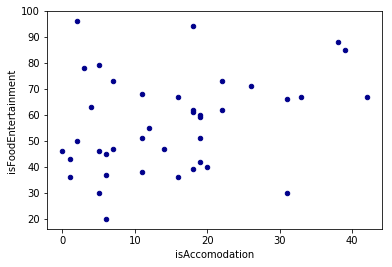

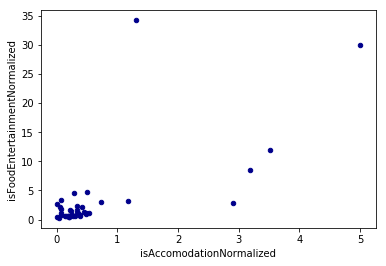

In [33]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline

sum_df.plot.scatter(x='isAccomodation',y='isFoodEntertainment',c='DarkBlue')
sum_df_normalised.plot.scatter(x='isAccomodationNormalized',y='isFoodEntertainmentNormalized',c='DarkBlue')

In [34]:
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

In [35]:
k_means = KMeans(init="k-means++", n_clusters=4, n_init=12)

In [36]:
X = sum_df.values
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [37]:
k_means_labels = k_means.labels_
k_means_labels

array([3, 2, 0, 3, 2, 0, 3, 0, 3, 0, 3, 3, 0, 0, 2, 0, 0, 1, 3, 0, 3, 0,
       0, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 0, 3, 2, 2, 1, 0, 2])

In [38]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[10.42105263, 40.73684211, 37.36414242, 24.76950449],
       [10.        , 95.        , 37.21548283, 26.2251279 ],
       [34.83333333, 74.        , 37.8781663 , 24.99362822],
       [13.53846154, 66.15384615, 38.05991454, 24.26782024]])

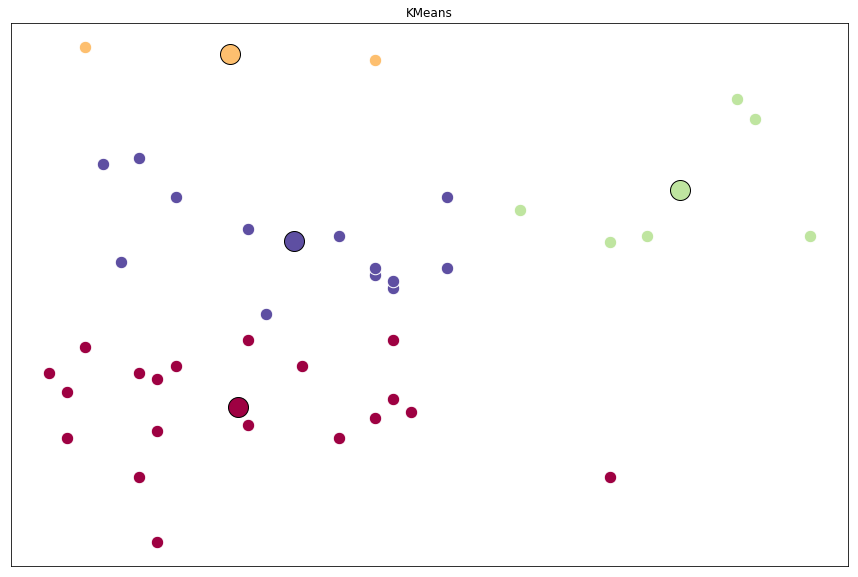

In [39]:
import numpy as np

# initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(15, 10))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

# create a plot
ax = fig.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):

    # create a list of all datapoints, where the datapoitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (k_means_labels == k)
    
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', markersize=25)
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=20)

# title of the plot
ax.set_title('KMeans')

# remove x-axis ticks
ax.set_xticks(())

# remove y-axis ticks
ax.set_yticks(())

# show the plot
plt.show()

In [40]:
#Convert the array to a dataframe
df_cluster_labels = pd.DataFrame(k_means_labels)

#get the index on the original dataframe in preparation for merging
sum_df = sum_df.reset_index(drop=False)

#merge the two datasets to get the cluster label
sum_df = sum_df.merge(df_cluster_labels, left_index=True, right_index=True)

#rename the cluster column
sum_df = sum_df.rename(index=str, columns={'0':'Label'})

In [41]:
sum_df.rename(index=str, columns={'0':'Label'},inplace=True)

In [43]:
sum_df.to_csv('Final_results.csv')